# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



In [1]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(f"l{i}", 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]



In [5]:
from ema_workbench import MultiprocessingEvaluator
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging
from ema_workbench.em_framework.evaluators import SOBOL

ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 1000
policy1 = Policy("no release", **{l.name:0 for l in lake_model.levers})
policy2 = Policy("release 0.05", **{l.name:0.05 for l in lake_model.levers})
policy3 = Policy("release 0.1", **{l.name:0.1 for l in lake_model.levers})
policies = [policy1, policy2, policy3]

with MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies, uncertainty_sampling=SOBOL)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 3 policies * 1 model(s) = 36000 experiments
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 18000 cases completed
[MainProcess/INFO] 21600 cases completed
[MainProcess/INFO] 25200 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32400 cases completed
[MainProcess/INFO] 36000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [17]:
from ema_workbench.em_framework import get_SALib_problem
from SALib.analyze import sobol
import pandas as pd

experiments, outcomes = results

problem = get_SALib_problem(lake_model.uncertainties)
y = outcomes['reliability'] #Focus on reliability objective

#Analyze the 3 different release policies
sobol_indices1 = sobol.analyze(problem, y[0:12000])
sobol_indices2 = sobol.analyze(problem, y[12000:24000])
sobol_indices3 = sobol.analyze(problem, y[24000:36000])

sobol_indices_list = [sobol_indices1, sobol_indices2, sobol_indices3]



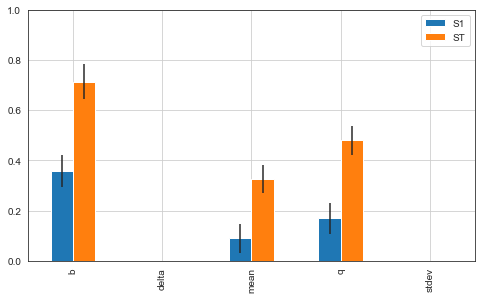

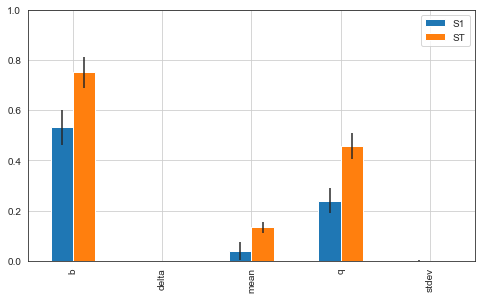

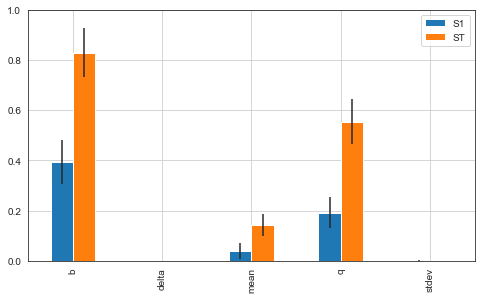

In [29]:
for n in range(0,3):
    sobol_stats = {key:sobol_indices_list[n][key] for key in ['ST', 'ST_conf', 'S1','S1_conf']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])
    sobol_stats.sort_values(by='ST', ascending=False)
    
    sns.set_style('white')
    fig, ax = plt.subplots(1)
    
    indices = sobol_stats[['S1','ST']]
    err = sobol_stats[['S1_conf','ST_conf']]
    
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.ylim([0,1])
    plt.grid()
plt.show()
    

Do the sensitivities change depending on the release policy? Can you explain why or why not?
- We can see by comparing the three plots of the three different policies that both the first order effect(S1) nd the Total effect (ST) change for all uncertatinties depending on the release policy. In all three cases the uncertainties b, mean and q, are the model inputs that add variance to the model reliability outcome, while delta and stdev having minimal influence.
B, the decay rate of P in the lake, is the model input with most influence in the variation of the reliability outcome. It has both relevant first order efect, as well as interactions with other variables. It is understanable since the relibaility (fraction of years where the pollution in the lake is below the critical threshhold) is highly influenced by how fast the phosphurus decays in the lake. Higher release policies haveinfluence in this outcome and also interactions with other uncertainties. First order effect of B seems to be lowest at "no release policy" and highest at "0.05 policy", but comes down again at "0.1 policy", however Total effects increase as the release policy is greater. this implies a threshhold to the first order effect of B, but an increasing amount of interactions, leading to a greater Total effect.



2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*


In [31]:
# Run SOBOL experiment results as input for EXTRA Trees

from ema_workbench.analysis import feature_scoring

# filter out the levers from experiment array
experiments, outcomes = results
clean = experiments.drop([f"l{i}" for i in range(100)], axis=1)
clean.head()

# Heatmaps
x = clean
y = pd.DataFrame.from_dict(outcomes)
fs1 = feature_scoring.get_feature_scores_all(x[0:12000], y[0:12000])
sns.heatmap(fs1, cmap='viridis', annot=True)
plt.show()


fs2 = feature_scoring.get_feature_scores_all(x[12000:24000], y[12000:24000])
sns.heatmap(fs2, cmap='viridis', annot=True)
plt.show()

fs3 = feature_scoring.get_feature_scores_all(x[24000:36000], y[24000:36000])
sns.heatmap(fs3, cmap='viridis', annot=True)
plt.show()

,b,delta,mean,q,stdev,scenario,policy,model
0,0.176904,0.935801,0.030742,3.691895,0.002121,12000,no release,lakeproblem
1,0.417529,0.935801,0.030742,3.691895,0.002121,12001,no release,lakeproblem
2,0.176904,0.932754,0.030742,3.691895,0.002121,12002,no release,lakeproblem
3,0.176904,0.935801,0.045977,3.691895,0.002121,12003,no release,lakeproblem
4,0.176904,0.935801,0.030742,3.252441,0.002121,12004,no release,lakeproblem


In [51]:
# Perform Experiments with LatinHypercube
from ema_workbench.em_framework.evaluators import LHS
n_scenarios = 1000
policy1 = Policy("no release", **{l.name:0 for l in lake_model.levers})
policy2 = Policy("release 0.05", **{l.name:0.05 for l in lake_model.levers})
policy3 = Policy("release 0.1", **{l.name:0.1 for l in lake_model.levers})
policies = [policy1, policy2, policy3]

with MultiprocessingEvaluator(lake_model) as evaluator:
    results_LHS = evaluator.perform_experiments(n_scenarios, policies, uncertainty_sampling=LHS)
    
experiments_LHS, outcomes_LHS = results_LHS

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


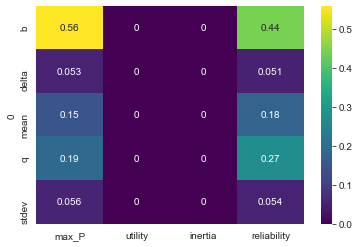

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


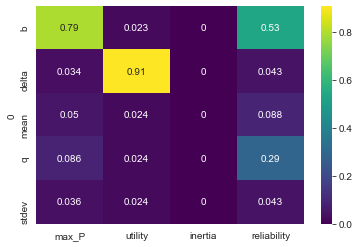

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


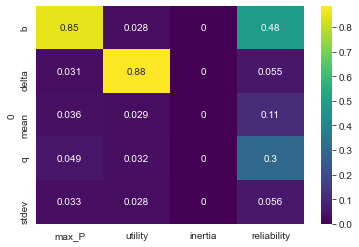

In [53]:
# Filter out the levers from experiment array

clean_LHS = experiments_LHS.drop([f"l{i}" for i in range(100)], axis=1)
clean_LHS.head()

# Heatmaps LHS
x = clean_LHS
y = pd.DataFrame.from_dict(outcomes_LHS)

fs1_LHS = feature_scoring.get_feature_scores_all(x[0:1000], y[0:1000])
sns.heatmap(fs1_LHS, cmap='viridis', annot=True)
plt.show()

fs2_LHS = feature_scoring.get_feature_scores_all(x[1000:2000], y[1000:2000])
sns.heatmap(fs2_LHS, cmap='viridis', annot=True)
plt.show()

fs3_LHS = feature_scoring.get_feature_scores_all(x[2000:3000], y[2000:3000])
sns.heatmap(fs3_LHS, cmap='viridis', annot=True)
plt.show()

Above we can see the graphs showing the feature scoring of all outcomes of interest. First with the Sobol experiment results and then using Latin Hypercube Sampling.
- Interestingly, for B, on both sampling methodologies, we can see the same tendency as seen in the Sobol Indices. The influence B has on the reliability outcome is higher on the 0.05 release policy, decreasing its first order influence when the release policy increases to 0.1.
- At the same time, although slightly different scores are attributed to the uncertainties. We can see that both sampling methods lead to similar tendencies, and provide us with insights of the relevant importance and influence certain parameters have on the outcomes of interest. In all release policies and both sampling methdos we can see that B has relevant influence in the Max_P outcome. In fact, this influence actually increases when the release policy is greater than 0. At the same time Delta is the main factor influencing the outcome Utility. OF course, when the "no release policy is present, this influence goes to 0.
- Since the policies where fixed at a certain point, there is no inertia in any of the release policies as there is no rate of change regarding the year-to-year decisions.
- This serves as an example to show that the Extra Trees method allows us to identify relevant uncertain parameters affecting certain model outputs, without the need of the computationally expensive Sobol. Nonetheless, both serve the purpose.